In [1]:
import os
import sys
from pathlib import Path
import datetime

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-09-24 
Git hash: 3e6018d790e56d8ccd70647a7eccff8c120a8e6d


In [3]:
# Connect to data store
store = pd.HDFStore('../sra.h5', mode='r')

In [4]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sra']
ncbi = db['ncbi']

In [5]:
complete = store['aln/complete'].srx.unique().tolist()

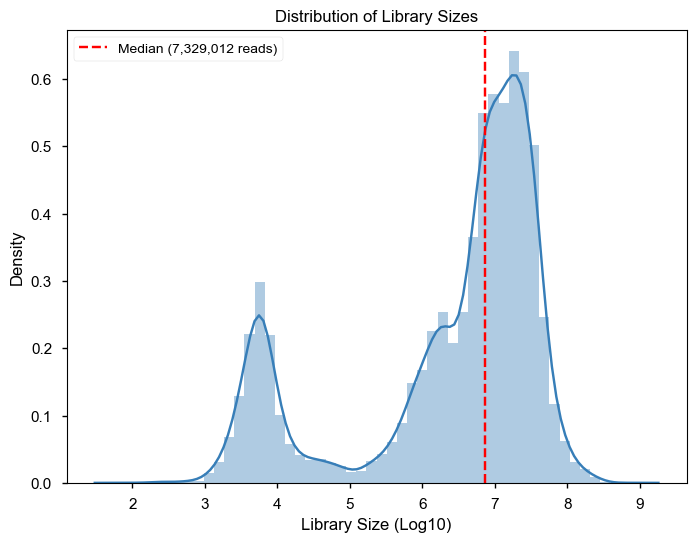

In [99]:
_dat = np.log10(store['prealn/workflow/fastq'][['libsize_R1', 'libsize_R2']].max(axis=1))
_med = _dat.median()
_med_num = int(np.ceil(10**_med))

fig, ax = plt.subplots()
sns.distplot(np.log10(store['prealn/workflow/fastq'][['libsize_R1', 'libsize_R2']].max(axis=1)), ax=ax)
ax.set_xlabel('Library Size (Log10)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Library Sizes')
ax.axvline(_med, color='r', ls='--', label=f'Median ({_med_num:,} reads)')
ax.legend(loc='upper left')

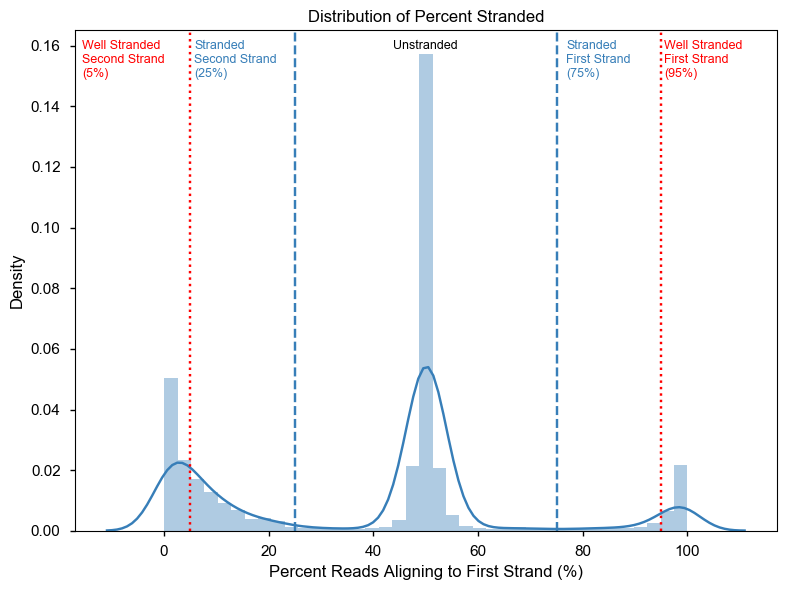

In [308]:
_dat = store['prealn/workflow/collectrnaseqmetrics/first'].PCT_CORRECT_STRAND_READS * 100

fig, ax = plt.subplots()
sns.distplot(_dat, ax=ax)

ax.axvline(25, ls='--')
ax.axvline(75, ls='--')

ax.axvline(5, ls=':', color='r')
ax.axvline(95, ls=':', color='r')

defaults = dict(va='top', transform=ax.transAxes, fontsize=9)
ax.text(0.5, .98, 'Unstranded', ha='center', **defaults)
ax.text(0.01, .98, 'Well Stranded\nSecond Strand\n(5%)', ha='left', color='r', **defaults)
ax.text(0.84, .98, 'Well Stranded\nFirst Strand\n(95%)', ha='left', color='r', **defaults)

ax.text(0.17, .98, 'Stranded\nSecond Strand\n(25%)', ha='left', color=_blue, **defaults)
ax.text(0.7, .98, 'Stranded\nFirst Strand\n(75%)', ha='left', color=_blue, **defaults)

ax.set_xlabel('Percent Reads Aligning to First Strand (%)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Percent Stranded')
plt.tight_layout()

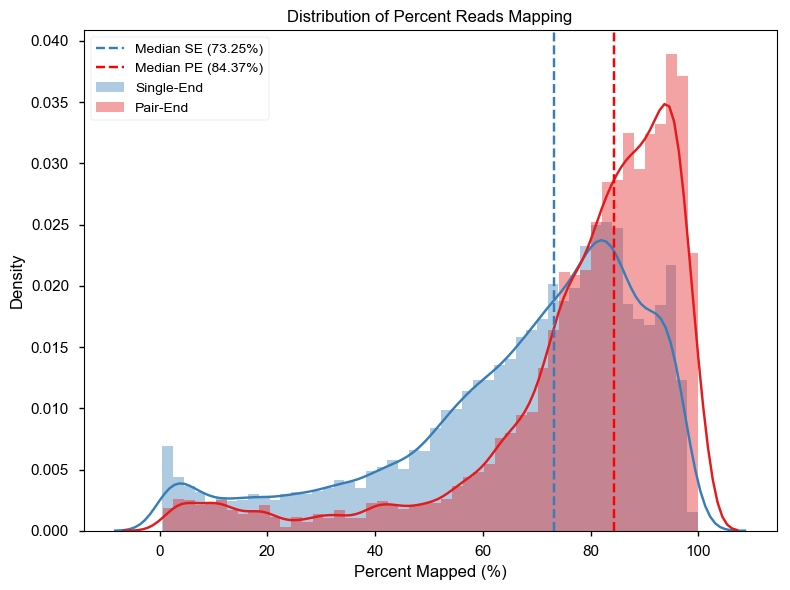

In [101]:
_layout = store['layout'].replace({'keep_R1': 'SE', 'keep_R2': 'SE'})
_dat = pd.concat([store['prealn/workflow/hisat2'], _layout], axis=1)
_se = _dat.query('layout == "SE"').per_alignment.dropna()
_pe = _dat.query('layout == "PE"').per_alignment.dropna()
_se_med = _se.median()
_pe_med = _pe.median()

fig, ax = plt.subplots(1, 1)
sns.distplot(_se, ax=ax, label='Single-End')
sns.distplot(_pe, ax=ax, label='Pair-End')
ax.axvline(_se_med, ls='--', label=f'Median SE ({_se_med:,}%)')
ax.axvline(_pe_med, ls='--', color='r', label=f'Median PE ({_pe_med:,}%)')
ax.set_xlabel('Percent Mapped (%)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Percent Reads Mapping')
plt.legend(loc='upper left')
plt.tight_layout()

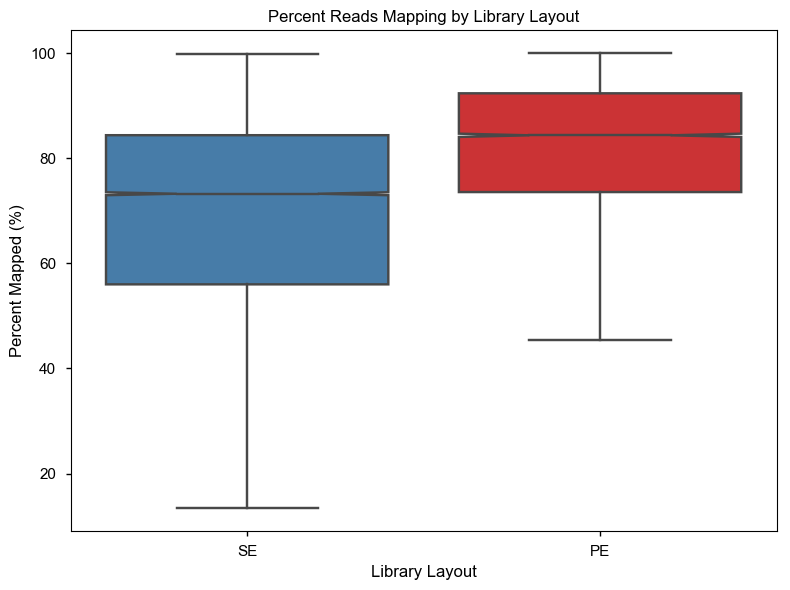

In [181]:
_layout = store['layout'].replace({'keep_R1': 'SE', 'keep_R2': 'SE'})
_dat = pd.concat([store['prealn/workflow/hisat2'], _layout], axis=1)

fig, ax = plt.subplots(1, 1)
sns.boxplot('layout', 'per_alignment', data=_dat, ax=ax, showfliers=False, notch=True)
ax.set_xlabel('Library Layout')
ax.set_ylabel('Percent Mapped (%)')
ax.set_title('Percent Reads Mapping by Library Layout')
plt.tight_layout()

In [102]:
_dat = store['prealn/workflow/hisat2'].per_alignment

In [151]:
_dates = pd.DataFrame(list(ncbi.aggregate([
    {
        '$unwind': {
            'path': '$sra.run'
        }
    },
    {
        '$unwind': {
            'path': '$biosample'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$sra.run.run_id',
            'date': '$biosample.submission_date'
        }
    }
])))

In [156]:
_dates.date = pd.to_datetime(_dates.date, format='%Y-%m-%d')

In [157]:
_dates = _dates.sort_values("date").set_index(['srx', 'srr']).date

In [158]:
_dat_w_date = pd.concat([_dat, _dates], axis=1).dropna()

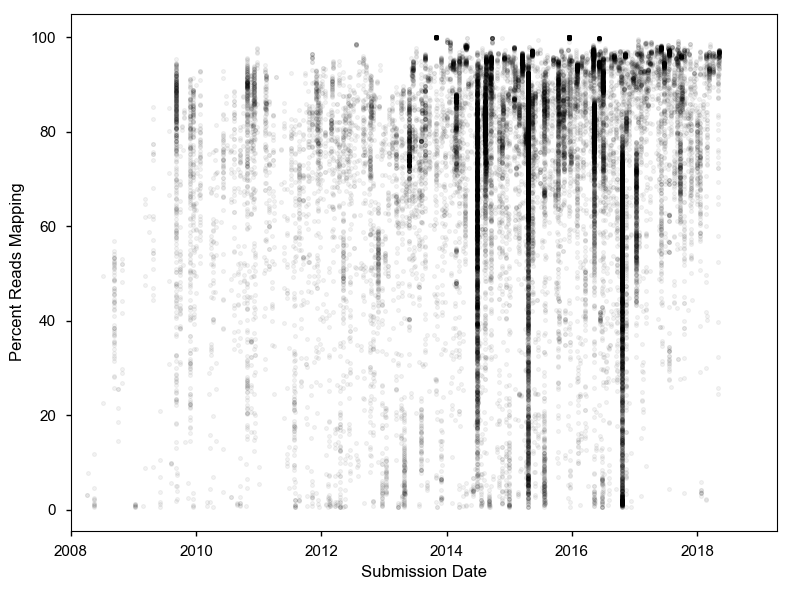

In [175]:
fig, ax = plt.subplots()
sns.scatterplot('date', 'per_alignment', data=_dat_w_date, s=8, alpha=0.05, ax=ax, color='k', edgecolor='k')
ax.set_xlim(datetime.date(2008, 1, 1), None)

ax.set_xlabel('Submission Date')
ax.set_ylabel('Percent Reads Mapping')

plt.tight_layout()

In [204]:
chroms = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrY', 'chrM']

def parse_idx(srx):
    _df = pd.read_parquet(f'../output/aln-wf/samtools_idxstats/{srx}.parquet')
    _dat = _df.reindex(chroms)['# mapped reads']
    _dat.name = srx
    return _dat

dfs = []
for srx in complete:
    dfs.append(parse_idx(srx))

_dat = pd.concat(dfs, axis=1).T

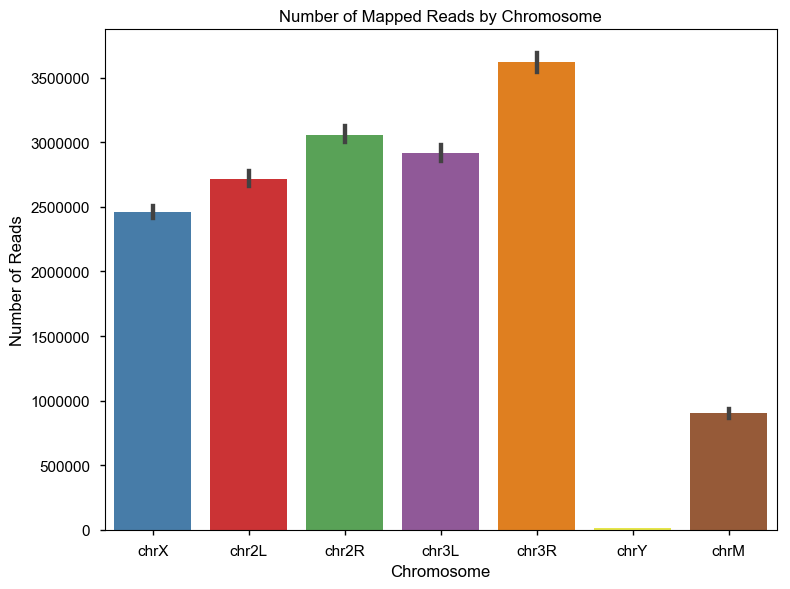

In [211]:
fig, ax = plt.subplots()
sns.barplot('chrom', 'value', data=_dat.melt(), ax=ax)
ax.set_title('Number of Mapped Reads by Chromosome')
ax.set_xlabel('Chromosome')
ax.set_ylabel('Number of Reads')
plt.tight_layout()

In [214]:
_srr_count = store['aln/complete'].groupby('srx').size()

In [220]:
_srx_w_multi_srr = _srr_count.index[_srr_count > 1].tolist()

In [222]:
len(_srx_w_multi_srr)

2739

In [278]:
files = [f'../output/prealn-wf/gene_counts/{x}.parquet' for x in _srx_w_multi_srr]

In [306]:
res = []
for fname in files:
    _dat = pd.read_parquet(fname).reset_index().pivot(values='count', columns='srr', index='FBgn')
    res.append(_dat.corr(method='spearman').min().min())

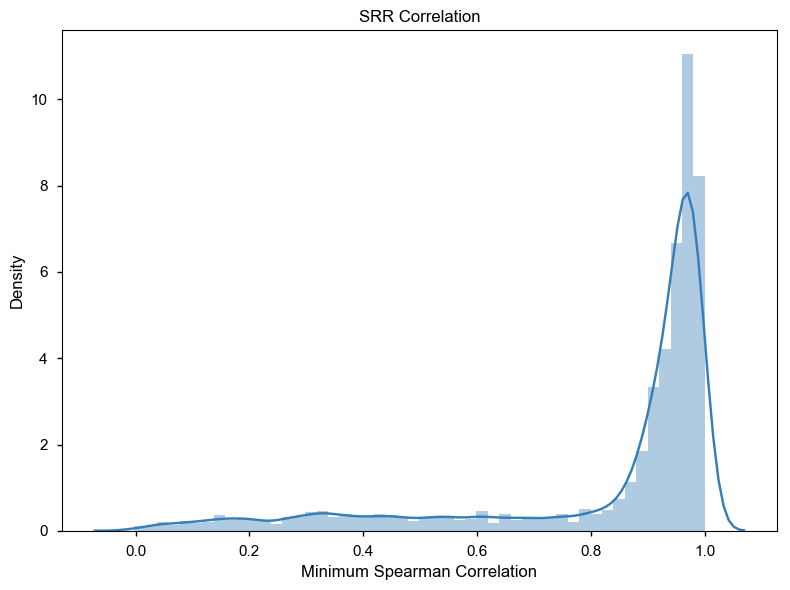

In [307]:
fig, ax = plt.subplots()
sns.distplot(res, ax=ax)
ax.set_title('SRR Correlation')
ax.set_xlabel('Minimum Spearman Correlation')
ax.set_ylabel('Density')
plt.tight_layout()